In [ ]:
import torch
from torch import nn
import torch.nn.functional as F
from torch.utils.data import Dataset, DataLoader
from torchvision.models import efficientnet_b0, EfficientNet_B0_Weights
import pandas as pd, numpy as np
import matplotlib.pyplot as plt
import transformers
from transformers import AutoTokenizer, AutoModelForCausalLM


In [2]:
# import torch_xla
# import torch_xla.core.xla_model as xm

In [3]:
#gpu
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")

# # tpu
# device = xm.xla_device()
# torch.set_default_tensor_type('torch.FloatTensor')

print(device)

cpu


In [4]:
DATA_PATH = '/kaggle/input/dobaehaza/'

In [5]:
pd.read_csv(f'{DATA_PATH}sample_submission.csv', index_col=0)

,vec_0,vec_1,vec_2,vec_3,vec_4,vec_5,vec_6,vec_7,vec_8,vec_9,...,vec_502,vec_503,vec_504,vec_505,vec_506,vec_507,vec_508,vec_509,vec_510,vec_511
id,,,,,,,,,,,,,,,,,,,,,
TEST_000,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
TEST_001,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
TEST_002,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
TEST_003,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
TEST_004,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
TEST_125,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
TEST_126,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
TEST_127,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0


In [6]:
test = pd.read_csv(f'{DATA_PATH}test.csv', index_col=0)

count = 0
for idx, i in enumerate(test.질문):
    if '또한' in i or '그리고' in i:
        count += 1
    else:
        print(i)
print(len(test.질문), count)
    

# 또한, 그리고

도배지에 녹은 자국이 발생하는 주된 원인과 그 해결 방법은 무엇인가요?
철골구조를 사용하는 고층 건물에서, 단열 효과를 높이기 위한 시공 방법은 무엇이 있을까요?
도배지의 완전한 건조를 위해 몇 주 동안 기다려야 하나요?
철근철골콘크리트 구조가 적용된 건물의 장단점은 무엇인가요?
도배지 들뜸 현상이 발생하는 가장 일반적인 원인은 무엇인가요?
도배지에 얼룩이 생기는 다양한 원인들에 대해서 자세히 알려주세요.
고층 건물을 건축할 때 철골구조가 주로 선택되는 이유는 무엇인가요?
유성페인트의 환경 오염에 대한 예시를 알려주세요.
철골콘크리트 구조에서 사용되는 철근의 재료적 특징은 무엇인가요?"
방염벽지가 실크벽지와 합지벽지와 다른 점은 무엇인가요?
도배지에 곰팡이가 생겼을 때 높은 습도가 원인인 경우, 습기 관리는 어떻게 해야 할까요?"
벽에 뚫린 구멍이 이상하다고 하셨는데, 타공 불량이 발생하는 원인과 그 해결 방법에 대해 자세히 설명해주실 수 있을까요?"
다이닝 룸을 더 고급스럽게 꾸밀려면 어떻게 해야 하나요와 아레카 야자를 키우면 어떤 이점이 있는지의 관계는 무엇인가요?
공동주택의 실내 공기질을 측정할 때, 어떤 층에서 샘플을 채취하는 것이 가장 적절한가요?"
반려동물을 위한 가구로 낮은 높이의 가구와 패브릭 소재의 가구가 선택되는 이유는 무엇인가요?
몰딩 수정을 예방하기 위해 건물 내부에서 어떤 종류의 환경 관리가 필요한가요?
페인트 하도재 없이 페인트를 바로 칠할 경우 어떤 문제가 발생할 수 있나요?
도배지에 생긴 반점을 없애기 위해 가장 효과적인 방법은 무엇인가요?
새집증후군의 주요 원인은 무엇인가요?
원목마루와 롱브릭타일에 대해 설명해주세요. 각각의 단점과 특징은 무엇인가요?
침실을 더 아늑하게 꾸밀 수 있는 방법에는 어떤 것이 있을까요와 아이가 있는 집을 꾸밀 때 안전을 위해 고려해야 할 요소는 무엇인가요의 관계는 무엇인가요?
그라스울 보온판의 주요 장점 중 하나인 흡음 성능은 어떻게 발휘될까요?"
미네랄울 보온판은 왜 고속 회전원심공법으로 제조되는 건

In [7]:
test.rename(columns={'질문': 'question'}, inplace=True)
test

,question
id,
TEST_000,"방청 페인트의 종류에는 어떤 것들이 있는지 알고 계신가요? 또한, 원목사이딩을 사용..."
TEST_001,도배지에 녹은 자국이 발생하는 주된 원인과 그 해결 방법은 무엇인가요?
TEST_002,"큐블럭의 단점을 알려주세요. 또한, 압출법 단열판을 사용하는 것의 장점은 무엇인가요?"
TEST_003,"철골구조를 사용하는 고층 건물에서, 단열 효과를 높이기 위한 시공 방법은 무엇이 있..."
TEST_004,도배지의 완전한 건조를 위해 몇 주 동안 기다려야 하나요?
...,...
TEST_125,분말 소화기를 사용할 때 주의해야 할 사항은 무엇인가요? 그리고 아파트 도배 평수를...
TEST_126,"압출법 보온판의 가장 큰 장점은 무엇인가요?"""
TEST_127,평지붕의 누수 문제를 방지하기 위해 수성 벽체용 탄성 방수 도료를 사용하는 것이 어...


In [8]:
train = pd.read_csv(f'{DATA_PATH}train.csv')
len(train)

644

In [9]:
answer = ['답변_1', '답변_2', '답변_3', '답변_4', '답변_5']
question = ['질문_1', '질문_2']

In [10]:
bag = []
for i in range(len(train)):
    row = train.iloc[i,:]
    bag.extend([{'id':row['id'], 'question':row[j], 'answer':row[i]} for j in question for i in answer])

train = pd.DataFrame(bag)
train.sample(10)

,id,question,answer
5507,TRAIN_550,"반려동물과 함께 살 때, 바닥에서 1미터 높이에 몰딩을 설치하는 이유는 무엇인가요?",1미터 높이에 몰딩을 설치하는 것은 반려동물과 함께 살 때 벽지를 보호하는 한 가지...
5934,TRAIN_593,어떻게 공간을 해변 풍으로 꾸밀 수 있을까요?,"해변 풍을 연출하려면 밝은 블루 톤의 컬러 팔레트를 활용하고, 바닷가를 상징하는 소..."
3381,TRAIN_338,도배지에 핀 곰팡이 제거 방법은?,"도배지에 핀 곰팡이는 교체가 필요합니다. 또한, 곰팡이가 석고보드나 도배지 안쪽 벽..."
3019,TRAIN_301,천연마루의 예상 수명은 얼마나 되나요?,천연마루의 기대수명은 일반적으로 50년 정도입니다. 그러나 제대로 관리되고 유지보수...
3913,TRAIN_391,수성 벽체용 탄성 방수 도료의 장점이 뭐야?,수성 벽체용 탄성 방수 도료의 장점은 다음과 같습니다. 1. 치밀한 표면구성과 ...
4219,TRAIN_421,퍼티작업은 건축 혹은 리모델링 작업 중에 벽이나 천정에 공극을 메우는 작업을 말합니...,"퍼티 작업은 페인트 시공을 하기 전에 수행되는 기초 작업으로, 석고보드의 이음메 부..."
3008,TRAIN_300,뮤럴벽지란 무엇인가요?,"뮤럴벽지는 그림이나 벽화를 뜻하며, 보통 맞춤 벽지로 제작되며 제작 과정에서 시간과..."
5900,TRAIN_590,스파티필름의 효과는 뭐야?,"연세대학교 의과대학교 분석실 실험에 따르면 스파티필름의 효과는 벤젠, 톨루엔, 에딜..."
1041,TRAIN_104,KMEW 세라믹 지붕재가 뭐야?,"KMEW 세라믹 지붕재는 일본의 기업인 KMEW에서 개발한 지붕재로, 산화티타늄 처..."
3173,TRAIN_317,하이샤시의 단점이 뭐야?,하이샤시의 단점은 알루미늄 샤시에 비해 가격이 높고 프레임이 두꺼워서 시인성이 떨어...


(array([2.184e+03, 3.488e+03, 4.940e+02, 1.720e+02, 7.200e+01, 2.400e+01,
        4.000e+00, 0.000e+00, 0.000e+00, 2.000e+00]),
 array([  17. ,  137.6,  258.2,  378.8,  499.4,  620. ,  740.6,  861.2,
         981.8, 1102.4, 1223. ]),
 <BarContainer object of 10 artists>)

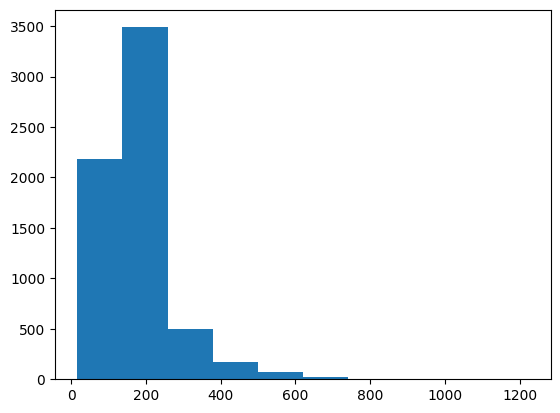

In [11]:
plt.hist([len(i) for i in train['answer']])

In [12]:
# 질문까지 학습 .. 너무 오래걸릴듯?

class QADataset(Dataset):
    def __init__(self, data, model_name, mode = 'train', max_token_len:int = 512, sample = 5000):
        self.data = data
        self.model_name = model_name
        self.tokenizer = AutoTokenizer.from_pretrained(model_name)
        self.max_token_len = max_token_len
        self.mode = mode
        self.sample = sample

    def __len__(self):
        return(len(self.data))

    def __getitem__(self, index):
        item = self.data.iloc[index]

        question = str(item.question)
        
        
        question_tokens = self.tokenizer.encode_plus(
                                            question,
                                            add_special_tokens=True,
                                            return_tensors='pt',
                                            truncation=True,
                                            max_length=self.max_token_len,
                                            padding='max_length',
                                            return_attention_mask=True)
        output = {'input_ids' : question_tokens.input_ids.flatten(), 'attention_mask' : question_tokens.attention_mask.flatten()}

        if self.mode == 'train':
            answer = str(item.answer)
            answer_tokens = self.tokenizer.encode_plus(answer,
                                                add_special_tokens=True,
                                                return_tensors='pt',
                                                truncation=True,
                                                max_length=self.max_token_len,
                                                padding='max_length')

            output['labels'] = answer_tokens.input_ids.flatten()


            return output

        else:
            return output




In [13]:
model_name = "beomi/kykim-gpt3-kor-small_based_on_gpt2"
# model_name = "guardrail/llama-2-7b-guanaco-instruct-sharded"

In [14]:
tokenizer = AutoTokenizer.from_pretrained(model_name)
model = AutoModelForCausalLM.from_pretrained(model_name)

tokenizer_config.json:   0%|          | 0.00/119 [00:00<?, ?B/s]

vocab.txt:   0%|          | 0.00/344k [00:00<?, ?B/s]

config.json:   0%|          | 0.00/620 [00:00<?, ?B/s]

pytorch_model.bin:   0%|          | 0.00/526M [00:00<?, ?B/s]

/opt/conda/lib/python3.10/site-packages/torch/_utils.py:831: UserWarning: TypedStorage is deprecated. It will be removed in the future and UntypedStorage will be the only storage class. This should only matter to you if you are using storages directly.  To access UntypedStorage directly, use tensor.untyped_storage() instead of tensor.storage()
  return self.fget.__get__(instance, owner)()


In [15]:
d_train = QADataset(train, model_name)

In [16]:
decoded_question = tokenizer.decode(d_train[0]['input_ids'])
decoded_answer = tokenizer.decode(d_train[0]['labels'])
decoded_question, decoded_answer

('[CLS] 면진장치가 뭐야? [SEP] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD

In [24]:
input_ids = tokenizer('놀러가자', return_tensors='pt').input_ids
generated_tokens = model.generate(input_ids=input_ids, attention_mask=None, max_length=30)
tokenizer.decode(generated_tokens[0], skip_special_tokens=False)

The attention mask and the pad token id were not set. As a consequence, you may observe unexpected behavior. Please pass your input's `attention_mask` to obtain reliable results.
Setting `pad_token_id` to `eos_token_id`:3 for open-end generation.
A decoder-only architecture is being used, but right-padding was detected! For correct generation results, please set `padding_side='left'` when initializing the tokenizer.


'[CLS] 놀러가자 [SEP] 안녕하세요. 오늘은 제가 좋아하는 영화 중 하나인 를 리뷰해보려고 합니다. [SEP]'

In [25]:
from torch.utils.data import DataLoader

d_train = QADataset(train, model_name)
d_test = QADataset(test, model_name)

train_dataloader = DataLoader(d_train, batch_size=16, shuffle=True)
val_dataloader = DataLoader(d_test, batch_size=16, shuffle=True)

In [26]:
from sklearn.model_selection import train_test_split

# 데이터 준비
X = train.question
y = train.answer

# 훈련 세트와 테스트 세트로 나누기
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2)

# train_data 생성
train_data = pd.DataFrame({'question': X_train, 'answer': y_train})
train_data.reset_index(drop=True, inplace=True)  # 인덱스 재설정

# val_data 생성
val_data = pd.DataFrame({'question': X_test, 'answer': y_test})
val_data.reset_index(drop=True, inplace=True)  # 인덱스 재설정

In [21]:
# pip install pytorch_lightning

In [27]:
import torch
from torch.utils.data import Dataset, DataLoader
from transformers import AutoTokenizer, AutoModelForQuestionAnswering
import pytorch_lightning as pl



class QADataModule(pl.LightningDataModule):
    def __init__(self, train_data, val_data, model_name, batch_size=16):
        super().__init__()
        self.train_data = train_data
        self.val_data = val_data
        self.model_name = model_name
        self.tokenizer = AutoTokenizer.from_pretrained(self.model_name)
        self.batch_size = batch_size

    def setup(self, stage=None):
        self.train_dataset = QADataset(self.train_data, self.model_name)
        self.val_dataset = QADataset(self.val_data, self.model_name)

    def train_dataloader(self):
        return DataLoader(self.train_dataset, batch_size=self.batch_size,num_workers=4, shuffle=True)

    def val_dataloader(self):
        return DataLoader(self.val_dataset, batch_size=self.batch_size, num_workers=4)

class QAModel(pl.LightningModule):
    def __init__(self, model):
        super().__init__()
        self.model = model

    def forward(self, input_ids, attention_mask, labels=None):
        output = self.model(
            input_ids=input_ids,
            attention_mask=attention_mask,
            labels=labels
        )
        return output

    def training_step(self, batch, batch_idx):
        input_ids = batch['input_ids'].long().to(device)
        attention_mask = batch['attention_mask'].long().to(device)
        labels = batch['labels'].long().to(device)
        output = self.forward(input_ids, attention_mask, labels)
        loss = output.loss
        self.log("train_loss", loss, prog_bar=True)
        return loss

    def validation_step(self, batch, batch_idx):
        input_ids = batch['input_ids'].long().to(device)
        attention_mask = batch['attention_mask'].long().to(device)
        labels = batch['labels'].long().to(device)
        output = self.forward(input_ids, attention_mask, labels)
        loss = output.loss
        self.log("val_loss", loss, prog_bar=True)
        return loss

    def test_step(self, batch, batch_idx):
        input_ids = batch['input_ids'].long().to(device)
        attention_mask = batch['attention_mask'].long().to(device)
        labels = batch['labels'].long().to(device)
        output = self.forward(input_ids, attention_mask, labels)
        loss = output.loss
        self.log("test_loss", loss, prog_bar=True)
        return loss

    def configure_optimizers(self):
        return torch.optim.Adam(self.parameters(), lr=1e-2)




model_name = "beomi/kykim-gpt3-kor-small_based_on_gpt2"
tokenizer = AutoTokenizer.from_pretrained(model_name)
model = AutoModelForCausalLM.from_pretrained(model_name)
# 데이터 모듈 생성
data_module = QADataModule(train_data, val_data, model_name, batch_size = 8)
data_module.setup()

# 모델 생성
model = QAModel(model)

# ADDITIONAL_TRAINING = True
MODEL_NUM = 11

# if ADDITIONAL_TRAINING:
#     model.load_state_dict(torch.load(f'{DATA_PATH}model_{MODEL_NUM}.ckpt'))

In [28]:
import torch, gc
gc.collect()
torch.cuda.empty_cache()

In [29]:
torch.cuda.device_count()

0

In [ ]:
from pytorch_lightning.callbacks import ModelCheckpoint


checkpoint_callback = ModelCheckpoint(
    filename='best-checkpoint',
    save_top_k=1,
    verbose=True,
    monitor='val_loss',
    mode='min'
)
trainer = pl.Trainer(
    accelerator='cpu',
    max_epochs=3,
    callbacks=[checkpoint_callback]
)

trainer.fit(model, data_module)

torch.save(model.state_dict(), f'model_{MODEL_NUM}.ckpt')


Sanity Checking: |          | 0/? [00:00<?, ?it/s]

huggingface/tokenizers: The current process just got forked, after parallelism has already been used. Disabling parallelism to avoid deadlocks...
To disable this warning, you can either:
	- Avoid using `tokenizers` before the fork if possible
	- Explicitly set the environment variable TOKENIZERS_PARALLELISM=(true | false)
huggingface/tokenizers: The current process just got forked, after parallelism has already been used. Disabling parallelism to avoid deadlocks...
To disable this warning, you can either:
	- Avoid using `tokenizers` before the fork if possible
	- Explicitly set the environment variable TOKENIZERS_PARALLELISM=(true | false)
huggingface/tokenizers: The current process just got forked, after parallelism has already been used. Disabling parallelism to avoid deadlocks...
To disable this warning, you can either:
	- Avoid using `tokenizers` before the fork if possible
	- Explicitly set the environment variable TOKENIZERS_PARALLELISM=(true | false)
huggingface/tokenizers: The 

Training: |          | 0/? [00:00<?, ?it/s]

In [26]:
# %load_ext tensorboard
# %tensorboard --logdir lightning_logs/

In [27]:
!ls

huggingface/tokenizers: The current process just got forked, after parallelism has already been used. Disabling parallelism to avoid deadlocks...
To disable this warning, you can either:
	- Avoid using `tokenizers` before the fork if possible
	- Explicitly set the environment variable TOKENIZERS_PARALLELISM=(true | false)


lightning_logs	model_304.ckpt	model_4.ckpt  model_5.ckpt  state.db


In [28]:
from IPython.display import FileLink
FileLink(f'model_{MODEL_NUM+1}.ckpt')

/kaggle/working/model_5.ckpt

In [29]:
tokenizer.decode(data_module.train_dataset[2]['input_ids'])

'[CLS] 뮤럴벽지가 뭐야? [SEP] 뮤럴벽지, 즉 벽화나 그림을 의미하는 맞춤벽지로서, 일반 벽지와는 달리 개인의 취향에 맞게 제작할 수 있는 특징이 있습니다. 그렇기 때문에 제작기간이 일반 벽지보다 길고, 가격도 비싸다는 단점이 있지만, 각인맞게 작업 가능하고 다양한 규격으로 맞춤제작이 가능하다는 장점이 있습니다. [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PA

In [39]:
with torch.no_grad():
    output = model(data_module.train_dataset[1]['input_ids'], data_module.train_dataset[1]['attention_mask'])
    generated_ids = torch.argmax(output.logits, dim=-1)
    generated_answer = tokenizer.decode(generated_ids, skip_special_tokens=True)
    print("Generated answer:", generated_answer)

Generated answer: ##의 페인트 페인트 페인트 초,,,,,,,,,,,,,,,,


In [31]:
with torch.no_grad():
    output = model(data_module.train_dataset[1]['input_ids'], data_module.train_dataset[1]['attention_mask'])
    generated_ids = torch.argmax(output.logits, dim=-1)
    generated_answer = tokenizer.decode(generated_ids, skip_special_tokens=True)
    print("Generated answer:", generated_answer)

Generated answer: ##의 페인트 페인트 페인트 초,,,,,,,,,,,,,,,,


In [38]:
with torch.no_grad():
    output = model(data_module.train_dataset[5]['input_ids'], data_module.train_dataset[5]['attention_mask'])
    generated_ids = torch.argmax(output.logits, dim=-1)
    generated_answer = tokenizer.decode(generated_ids, skip_special_tokens=True)
    print("Generated answer:", generated_answer)

Generated answer: ##의폼재폼재재재,,,,,,,,,,,,,재,,,,,,,,,,


In [33]:
checkpoint_callback.best_model_path

'/kaggle/working/lightning_logs/version_2/checkpoints/best-checkpoint.ckpt'

In [34]:
# 모델 저장
torch.save(model.state_dict(), 'model_304.ckpt')

# 모델 정의
# model = YourModelClass()

# 저장된 가중치 로드
# model.load_state_dict(torch.load('model.ckpt'))